In [1]:
using LinearAlgebra                                                             
using Test                                                                                       
using Distributions                                                             
using DataFrames                                                                          
using CSV                                                                              
using Polynomials  
                                                                                 
include("../computation/finitedifference.jl")                                                   
include("../quadrature/quadrature.jl")                                             
include("../transforms/transforms.jl")                                             
include("../priors/priors.jl")                                                     
include("../bayesopt/incremental.jl")                                              
include("../kernels/kernel.jl")                                                    
include("../datastructs.jl")                                                       
include("../computation/buffers0.jl") #datastruct, kernel, incremental, quadrature 
include("../model0.jl") #buffers, datastructs, several auxiliary                   
include("../computation/tdist.jl") #model0 and buffer0  

comp_tdist

In [71]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [80]:
# Data and setup for different tests

# choice of covariate functions
p = 1
p = 3

# training
x1 = 4 .* rand(nx, 2) .- 2 
x2 = [-0.28340   0.62098;
     -1.59902   1.86275;
      0.49347  -1.46311;
      1.50624  -1.42874; 
      1.57966  -1.4987;  
     -1.35577   0.33419;
      1.57967   0.4927;  
      1.30226   1.30865; 
      1.84554  -1.71706; 
      1.45705   0.264961]
x3 = [-0.801151   -0.543169;   
      -0.94552     1.09677;    
       0.947512   -0.827147;   
      -1.42516     0.916257;   
      -1.35157     0.449443;   
       0.266677    1.31536;    
      -0.555493    0.841922;   
      -0.0235545   0.000649033;
      -0.339027    0.843967;   
      -1.7816      1.52251; ]

# testing
x01 = 4 .*rand(1, 2) .- 2
x02 = [-1.0097 0.3929]
x03 = [-0.936599  -1.94613]

# underlying 2d function 
test_fun1(x, y) = x^2 * exp(- x^2 - y^2) 


test_fun1 (generic function with 1 method)

# Summary
Settings parameters: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data

Tests:
1. p=3 or p=1, x=x2, x0=x02 \
   pdf blows up near 0, numerical issue (g'(y0) blows up when y0~=0?)
2. p=1, x=x3, x0=x03 \
    pdf weird shape (no peak, uniformish)
3. p=3, x=x3, x0=x03 \
    pdf blows up near 0, and pdf support ~= $[0,5]$

In [85]:
# parameter setting: change for different tests

p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x3 # choose training data 
x0 = x03 # choose testing data
test_fun = test_fun1 # choose underlying function

#####################################

# setup values and covariates (no changes needed)
Fx = covariate_fun(x, p)
y = [test_fun(_x[1], _x[2]) for _x in zip(x[:,1], x[:,2])]
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

Fx0 = covariate_fun(x0, p)
y0_true = test_fun(x0[1], x0[2])/ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")


Prediction at x0 = [-0.936599 -1.94613]
Covariates at x0: [1.0]
Should expect peak near 0.03286481634183594


trainingData([-0.801151 -0.543169; -0.94552 1.09677; … ; -0.339027 0.843967; -1.7816 1.52251], [1.0; 1.0; … ; 1.0; 1.0], [1.0, 0.43663144201603993, 0.7338171864726465, 0.4576033210508781, 0.9551187910061221, 0.04668018187390902, 0.44356252266100166, 0.0022047418193966426, 0.19983095330496892, 0.05198373342080949], 2, 1, 10)

In [86]:
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 150]
rangeλ = [0.5 5]

1×2 Array{Float64,2}:
 0.5  5.0

In [87]:
btg1 = btg(trainingData1, rangeθ, rangeλ);
(dpdf, pdf, cdf) = solve(btg1);
dpdf_fixed = y0 -> dpdf(x0, Fx0, y0) 
pdf_fixed = y0 -> pdf(x0, Fx0, y0)
cdf_fixed = y0 -> cdf(x0, Fx0, y0)

Iterating over nodeset to build train_buffer_dict...
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12


#185 (generic function with 1 method)

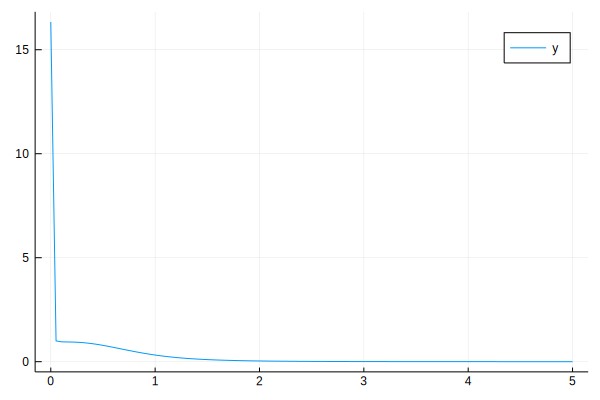

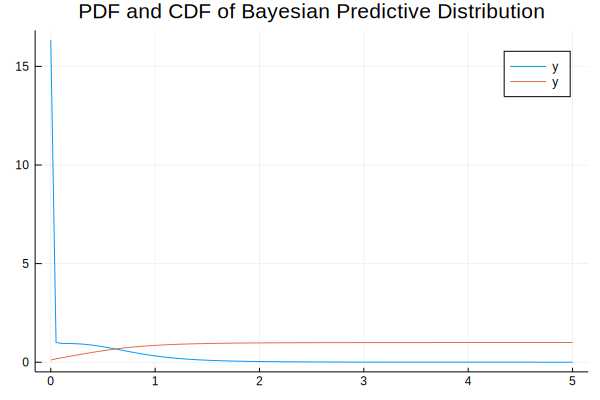

([1.0e-5, 0.0505149494949495, 0.10101989898989899, 0.1515248484848485, 0.202029797979798, 0.2525347474747475, 0.303039696969697, 0.3535446464646465, 0.404049595959596, 0.4545545454545455  …  4.545455454545454, 4.595960404040404, 4.646465353535353, 4.696970303030303, 4.747475252525253, 4.797980202020202, 4.848485151515152, 4.898990101010101, 4.949495050505051, 5.0], [0.10991313962275373, 0.17367783837191236, 0.22272463989295588, 0.27077483382150486, 0.3185952416471261, 0.3660876139482856, 0.41292717996973927, 0.45872905642671014, 0.5031127415584193, 0.5457331879190542  …  0.9991455209396893, 0.9991851463025629, 0.9992226150163435, 0.9992580616255713, 0.9992916112247001, 0.9993233801947374, 0.999353476876899, 0.9993820021891349, 0.9994090501907841, 0.9994347086001043])

In [88]:
plt(pdf_fixed, 1e-5, 5, 100)
plt!(cdf_fixed, 1e-5, 5, 100, title = "PDF and CDF of Bayesian Predictive Distribution")